In [1]:
%pip install pandas
%pip install yfinance
%pip install matplotlib
%pip install seaborn
%pip install statsmodels
%pip install tensorflow
%pip install setuptools

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [5]:
# prompt: download btc-usd from yfinance and put it in an df variable

df = yf.download('BTC-USD', start='2014-09-17', end='2023-04-01')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


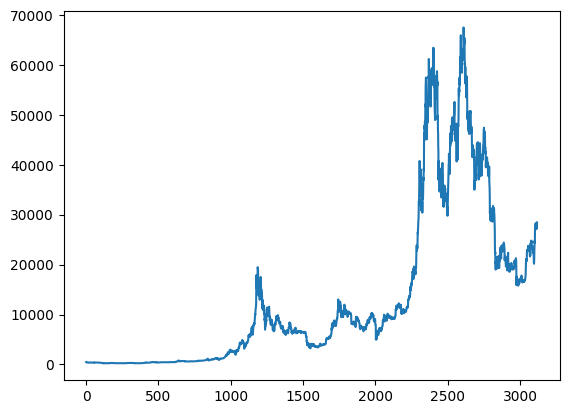

In [6]:
df2 = df.reset_index()['Close']
plt.plot(df2)

In [7]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(3118, 1)

In [8]:
train_size = int(len(df2)*0.65)
test_size = len(df2) - train_size
train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1]

In [9]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [10]:
# calling the create dataset function to split the data into
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [11]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(1925, 100)
[[0.00414359 0.00365546 0.00321557 ... 0.00232189 0.00214325 0.00209093]
 [0.00365546 0.00321557 0.00342492 ... 0.00214325 0.00209093 0.00222324]
 [0.00321557 0.00342492 0.0032753  ... 0.00209093 0.00222324 0.00204426]
 ...
 [0.10882363 0.10650929 0.10601817 ... 0.08998673 0.08523592 0.09277129]
 [0.10650929 0.10601817 0.10531514 ... 0.08523592 0.09277129 0.09290191]
 [0.10601817 0.10531514 0.10477812 ... 0.09277129 0.09290191 0.09539687]]
(991, 100)
(991,)


In [12]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 0.0026 - val_loss: 0.0071
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 1.8865e-04 - val_loss: 0.0070
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - loss: 1.4547e-04 - val_loss: 0.0049
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 1.6243e-04 - val_loss: 0.0122
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - loss: 1.2544e-04 - val_loss: 0.0109
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - loss: 1.1834e-04 - val_loss: 0.0125
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 1.1363e-04 - val_loss: 0.0116
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - loss: 9.5000e-05 - val_loss: 0.0194
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 1.7718e-04 - val_loss: 0.0127
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 9.1753e-05 - val_loss: 0.0085
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - loss: 1.1657e-04 - val_loss: 0.013

In [16]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [17]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [18]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

5788.897432156998
32925.113508113565


In [19]:
look_back = 100

In [20]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [21]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

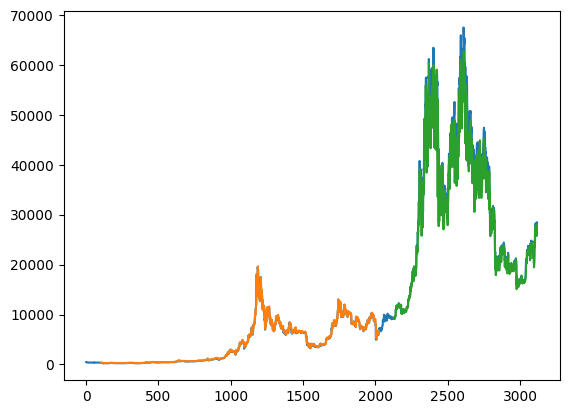

In [22]:
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# AAAAAAAAAAAAAAAAAAAAAA
